# Read in the data

In [2]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plot Correlations

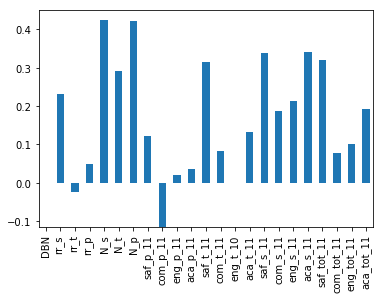

In [11]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

High correlations: N_s, N_t,N_p   saf_t_11, saf_s_11, aca_s_11, saf_tot_11

The first three N_s, N_t, and N_p are number of student, teacher, and parent respondents and so are a proxy for school size, which we already know is correlated positively with sat score. It looks like rr_s is also slightly positively correlated with sat_score. This is student response rate, so schools with higher response rates did a little better on the SAT.

Percenption of safety by students and teachers coorelated with SAT score (saf_s_11,saf_t_11,saf_tot_11). However, parents perception of safety (saf_p_11) was much lower indicator of SAT score.

Students perceptions of academic standards (aca_s_11) correlate positively with SAT score. However, teacher and parent perception of academic standards (aca_t_11, aca_p_11) are not highly correlated.


# Safety and SAT scores

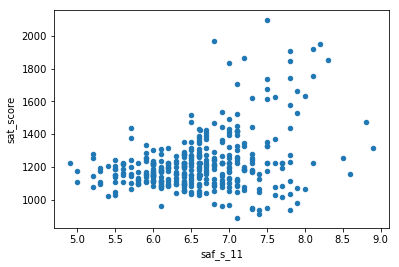

In [13]:
combined.plot.scatter(x="saf_s_11",y="sat_score")

The correlation between student perception of safety and sat score is not strong. There is a group of schools with very high average SAT scores and high safety scores. No school with a safety score below 6.5 had an average SAT score higher than 1500.

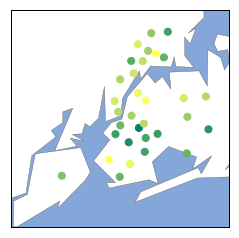

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(numpy.mean)
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes,latitudes,s=50,zorder=2,latlon=True,c=districts["saf_s_11"], cmap="summer")
plt.show()

It looks like Upper Manhattan and parts of Queens and the Bronx tend to have lower safety scores, whereas Brooklyn has high safety scores.

# Exploring Race in SAT scores

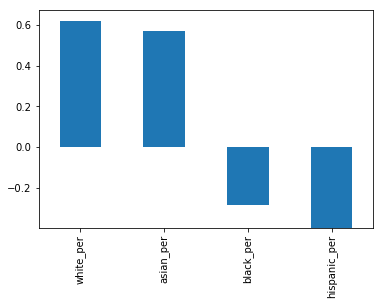

In [17]:
race_columns = ["white_per","asian_per","black_per","hispanic_per"]
combined.corr()["sat_score"][race_columns].plot.bar()

There is a positive correlation between white and asian percentage and SAT score and a negative correlation between black and hispanic percentage and SAT score.

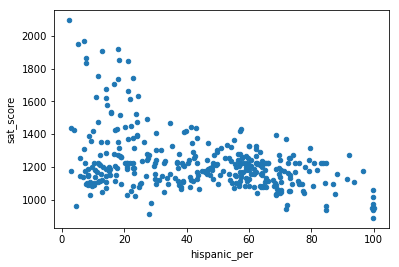

In [18]:
combined.plot.scatter(x="hispanic_per",y="sat_score")

It looks like there at the low end of hispanic percentage, SAT scores get much higher. No school with over 40% hispanic students had an average SAT score over 1500.

In [22]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools have a lot of recent immigrants.

In [23]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These are STEM high schools that require an entrace exam.

# Gender and SAT scores

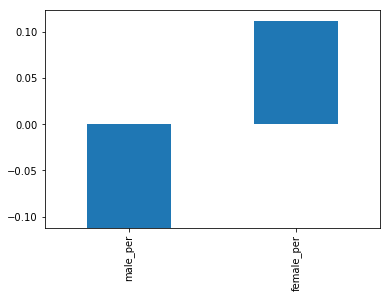

In [27]:
gender_columns = ["male_per","female_per"]
combined.corr()["sat_score"][gender_columns].plot.bar()

There is a weak correlation indicating higher SAT scores at schools with a higher percentage of girls.

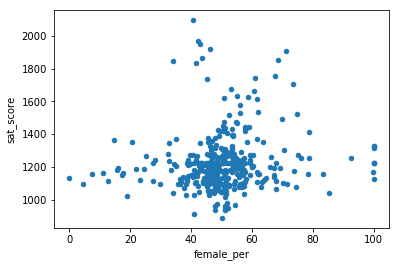

In [28]:
combined.plot.scatter("female_per", "sat_score")

In [29]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These are very selective liberal arts schools with high academic standards.

# AP Scores vs SAT Scores

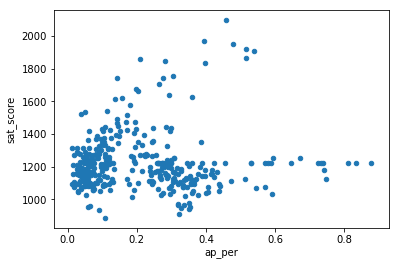

In [30]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
combined.plot.scatter(x="ap_per",y="sat_score")

Not a strong correlation in general. There is a group of schools with a decently high ap_per (>20%) and very high SAT scores.

# Class Size and SAT scores

0.38101433081


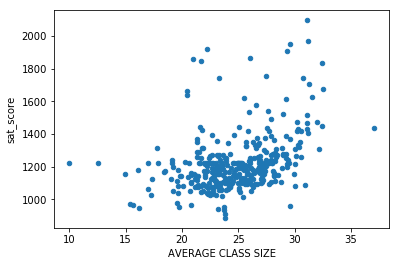

In [35]:
combined.plot.scatter(x="AVERAGE CLASS SIZE",y="sat_score")
print(combined.corr()["sat_score"]["AVERAGE CLASS SIZE"])

# Best performing areas

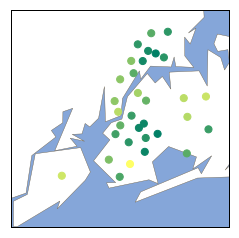

In [37]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes,latitudes,s=50,zorder=2,latlon=True,c=districts["sat_score"], cmap="summer")
plt.show()

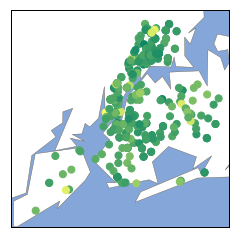

In [38]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = combined["lon"].tolist()
latitudes = combined["lat"].tolist()
m.scatter(longitudes,latitudes,s=50,zorder=2,latlon=True,c=combined["sat_score"], cmap="summer")
plt.show()

# Student v Parent v Teacher Survey Responses

In [40]:
survey_fields

['DBN',
 'rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_10',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

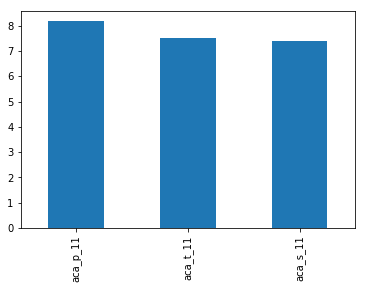

In [46]:
safety_fields = ["saf_p_11","saf_t_11","saf_s_11"]
com_fields = ["com_p_11","com_t_11","com_s_11"]
eng_fields = ["eng_p_11","eng_t_11","eng_s_11"]
aca_fields = ["aca_p_11","aca_t_11","aca_s_11"]

averages = combined.mean()
averages[safety_fields].plot.bar()


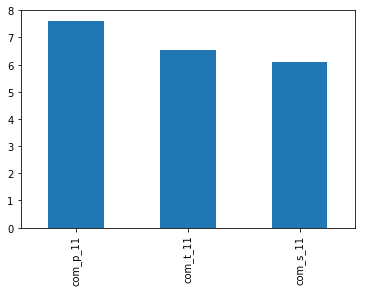

In [47]:
averages[com_fields].plot.bar()

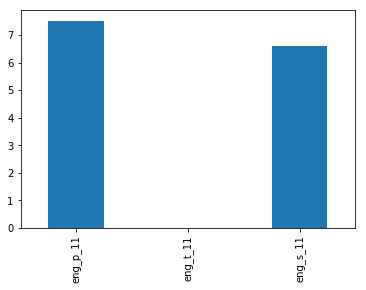

In [48]:
averages[eng_fields].plot.bar()

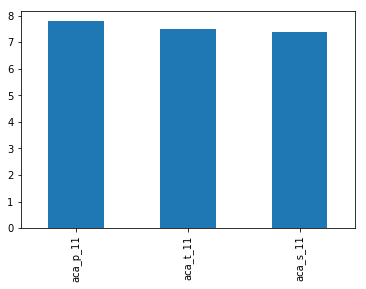

In [49]:
averages[aca_fields].plot.bar()

It is interesting that for each field, parents answers were higher than teachers answer and both were higher that the scores students gave.

# Scoring Schools

Combined SAT scores, safety score, 

In [ ]:

combined["score"] = 